## Local deploying and serving 
Servir et interroger des modèles localement est très simple et peut être effectué en ligne de commande. Si vous souhaitez simplement servir le dernier modèle, vous pouvez le faire en utilisant l'ID du run .

Avant de commencer, accédez à nouveau à l'interface utilisateur de MLFlow et cliquez sur l'expérience scikit_learn_experiment. Choisissez une exécution et copiez l'ID de l'exécution. N'oubliez pas non plus le nom du modèle avec lequel vous avez enregistré le modèle, qui devrait être log_reg_model. 


In [1]:
import pandas as pd
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix
import numpy as np
import subprocess
import json

c:\Users\um6p\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Tout d'abord, vous devez remplacer votre répertoire par un répertoire contenant le dossier mlruns avec toutes vos expériences. Ensuite, vous avez besoin de deux choses : l'ID du run de votre modèle et le nom de votre modèle. 

Une fois vous aurez ces information, exécutez cette commande:

> mlflow models serve --model-uri runs:/YOUR_MODEL_RUN/YOUR_MODEL_NAME -p 1235

MLFlow devrait commencer à construire immédiatement un nouvel environnement conda qu'il utilisera pour servir localement. Dans cet environnement, il installe des packages de base et des packages spécifiques que le modèle doit pouvoir s'exécuter.

notre modèle est servi sur : http://localhost:1235/ 

### Interroger le modèle 

Vous êtes maintenant prêt à interroger le modèle avec des données et à recevoir des prédictions. C'est là qu'intervient le module subprocess (ou requests). Tout d'abord, chargeons à nouveau notre dataframe. Exécutez le code suivant : 

#### Interrogation en utilisant subprocess

In [2]:
df = pd.read_csv("data/creditcard.csv")

In [3]:
input_json = df.iloc[:80].drop(["Time", "Class"],axis=1).to_json(orient="split")
input_json
# nous allons extraire 80 valeur pour interroger mle modèle avec

'{"columns":["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount"],"index":[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79],"data":[[-1.3598071337,-0.0727811733,2.536346738,1.3781552243,-0.3383207699,0.4623877778,0.2395985541,0.0986979013,0.3637869696,0.090794172,-0.5515995333,-0.6178008558,-0.9913898472,-0.3111693537,1.4681769721,-0.4704005253,0.2079712419,0.0257905802,0.4039929603,0.2514120982,-0.0183067779,0.2778375756,-0.1104739102,0.0669280749,0.1285393583,-0.1891148439,0.1335583767,-0.0210530535,149.62],[1.1918571113,0.2661507121,0.1664801134,0.4481540785,0.0600176493,-0.0823608088,-0.0788029833,0.0851016549,-0.2554251281,-0.166974414,1.6127266611,1.0652353114,0.4890950159,-0.1437722964,

In [4]:
proc = subprocess.run(["curl", "-X", "POST", "-H","Content-Type:application/json; format=pandas-split",
"--data", input_json, "http://127.0.0.1:1235/invocations"],
stdout=subprocess.PIPE, encoding='utf-8')

In [5]:
output = proc.stdout
print(output)
#df2 = pd.DataFrame([json.loads(output)])
#df2

#### Interrogation en utilisant requests 

In [6]:
import requests

In [7]:
import requests

host = '127.0.0.1'
port = '1235'

url = f'http://{host}:{port}/invocations'

headers = {
    'Content-Type': 'application/json',
}
r = requests.post(url=url, headers=headers, data=input_json)

print(f'Predictions: {r.text}')

Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


ce que nous avons fait en haut (subprocess ou request) est équivalent à exécuter la commande ci-dessous sur l'invité de commande:

> curl -X POST -H "Content-Type:application/json;
format=pandas-split"
–data "CONTENT_OF_INPUT_JSON"
"http://127.0.0.1:1235/invocations"

Le cœur du problème est que si vous exécutez cela en ligne de commande, coller les données au format JSON peut devenir très compliqué car il y a tellement de colonnes. C'est pourquoi nous avons choisi d'utiliser subprocess ou requests car il est plus facile de transmettre directement le JSON lui-même en utilisant un nom de variable, input_json dans ce cas, pour contenir le contenu du JSON. 

#### Batch querying 

Malheureusement, il y a un maximum d'enregistrements qu'on peut envoyer pour la prédiction (presque 80).

Afin de remédier à ce problème, nous pouvons essayer de batcher nos données et faire une prédiction à chaque batch de données.

nous allons refaire la même chose avec scaling.

In [8]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]
normal_train, normal_test = train_test_split(normal,
test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(["Time", "Class"],
axis=1))
test = df.iloc[:8000]
true = test.Class
test = scaler.transform(test.drop(["Time", "Class"], axis=1))
preds = []
batch_size = 80
for f in range(100):
    sample = pd.DataFrame(test[f*batch_size:(f+1)*batch_size]).to_json(orient="split")
    proc = subprocess.run(["curl", "-X", "POST", "-H","Content-Type:application/json;format=pandas-split", "--data",sample, "http://127.0.0.1:1235/invocations"],stdout=subprocess.PIPE,encoding='utf-8')
    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds, resp.values[0]))
eval_acc = accuracy_score(true, preds)
eval_auc = roc_auc_score(true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.999375
Eval AUC 0.9398746081504702


Ici, vous sélectionnez les 8 000 premiers échantillons du dataframe. Étant donné que la taille du lot est de 80, vous avez 100 lots que vous transmettez au modèle 

Text(0.5, 1.0, 'Confusion Matrix')

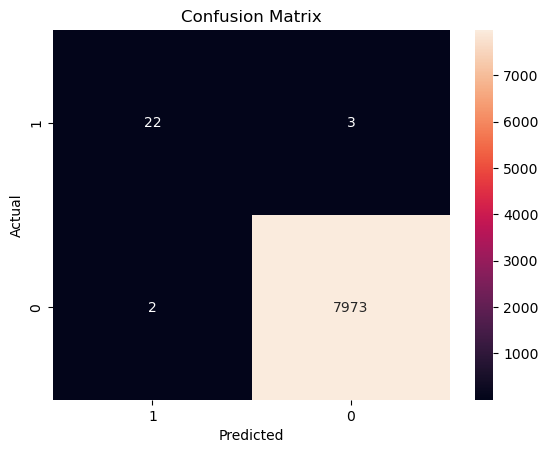

In [9]:
conf_matrix = confusion_matrix(true, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")